In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.figsize'] = [12, 8] 
plt.rcParams.update({'font.size': 25})


A tutorial on analysing the inference of effective population size over time ($N_e(t)$) or coalescence times from PSMC+. 

Last updated 21st December 2023. 

# Inference of $N_e(t)$

It is easy to plot the inference of PSMC+. Suppose your output files are: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/CLM_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/GBR_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/JPT_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/BEB_final_parameters.txt<br>
<br>
(Inference here used D=64, b=100, mu_over_rho_ratio=1.5, its=30,spread_1=0.05, spread_2=50)<br><br>
Then you can do: 

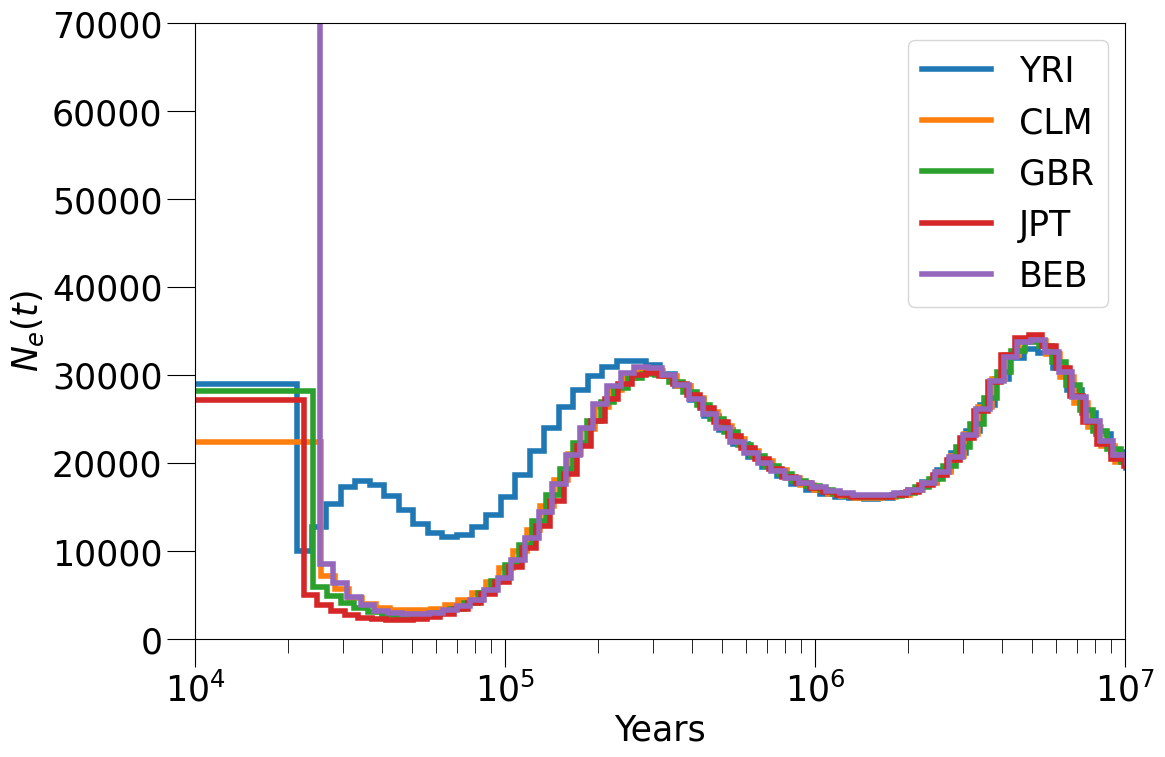

In [20]:
mu = 1.25e-08
gen = 29

for population in ['YRI','CLM','GBR','JPT','BEB']:
    final_params_file = f'/home/trevor/PSMCplus_tutorial/inferencedata/{population}_final_parameters.txt'
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=population,linewidth=4,linestyle="solid",baseline=None)

plt.xlim(1e+04,1e+07)
plt.ylim(0,7e+04)
plt.xscale('log')
plt.ylabel('$N_e(t)$')
plt.xlabel('Years')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.legend()
plt.show()


# Inference of coalescence times across the genome

Suppose we want to decode one of the YRI chromosomes as used in inference above. Ideally, we want to use the inferred $N_e(t)$ parameters to do this. We can do this by extracting the inverse coalescence parameters from the "final_parameters.txt" file:  

In [52]:
# extract parameters from inference

final_parameters = np.loadtxt('/home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt') # load final parameters
ztheta = !cat /home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt | grep theta # get theta from file
theta = float(ztheta[0].split(' ')[-1]) 
zrho = !cat /home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt | grep rho # get rho from file
rho = float(zrho[0].split(' ')[-1]) 
lambda_parameters = final_parameters[:,2]*theta/4 # get lambda parameters (the inverse coalescence rates) in coalescent units
lambda_parameters_string = ",".join([str(i) for i in lambda_parameters]) # make it a comma separated string
infile = '/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20.mhs'
outfile = '/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz'

In [63]:
# set the command line string, using same parameters as inference. Save every 1000 base pairs only (b*decode_downsample=1000)
commandline = f'python /home/trevor/PSMCplus/PSMCplus.py -in {infile} -D 64 -b 100 -spread_1 0.05 -spread_2 50 -theta {theta} -rho {rho} -lambda_A_fg {lambda_parameters_string} -o {outfile} -decode -decode_downsample 10'

In [64]:
!{commandline} # this took my laptop about 25 seconds


Running PSMCplus; last updated 230925ymd; v1.1
Command line: python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20.mhs -D 64 -b 100 -spread_1 0.05 -spread_2 50 -theta 0.0009998188109354466 -rho 0.0004119061061395524 -lambda_A_fg 0.6906809583208723,2.0138872921537407,1.5794250715012357,1.3046549151597842,1.1615605116804073,1.1160343160593473,1.1453122849912245,1.2353473745554213,1.3726054623506154,1.5305165445696525,1.6640677378925508,1.7265897183287557,1.695479811768646,1.5823176724990717,1.4191558519657856,1.2406487568168385,1.0751755208725366,0.93859280739646,0.8349754731539164,0.7600899785923266,0.7073090567763702,0.6706845746634192,0.6467080421091825,0.6342547255131511,0.6330082149976504,0.642934892289605,0.6642542859697635,0.6964194947949228,0.7384775034777215,0.7889033637403136,0.8454410126893845,0.9055748649719878,0.9667574071617051,1.027278235385956,1.0842111956074834,1.1359728669869584,1.1804213819282643,1.2159637472576523,1.24153833

We can either visualise the posterior distribution with a heatmap, or take the posterior mean and see how this changes across the genome. 

In [122]:
decoding = np.loadtxt('/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz') # load the decoding file
positions = decoding[0,:] # get position array
posteriors = decoding[1:,] # get posteriors

time_coalescent_string = !zcat /home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz | head -6 | tail -1 # get 
time_coalescent = np.array([float(i) for i in time_coalescent_string[0].split(' ')[1].split(',')])
N = theta/(4*mu) # get N
time_years = time_coalescent*2*N*gen # get time in years
time_years_midpoints = np.array([(time_years[i]+time_years[i+1])/2 for i in range(0,64)]) # get the midpoints of the time boundaries

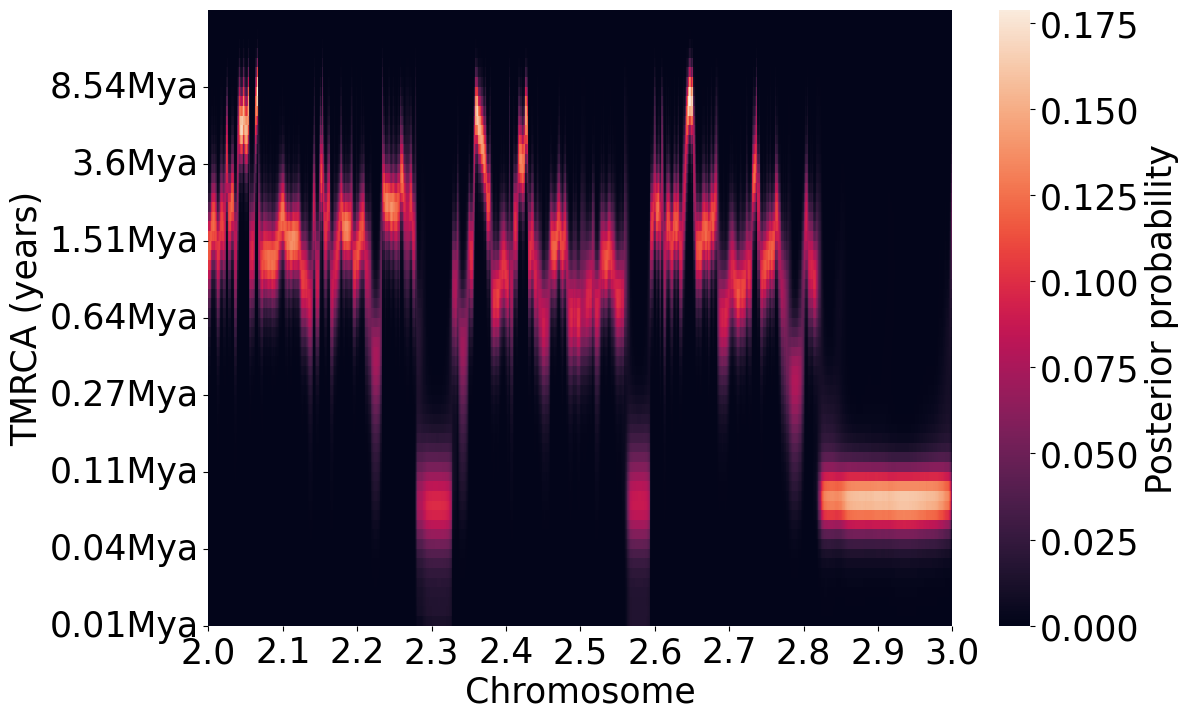

In [176]:
# heatmap 

start = 2000
end = 3000
ax = sns.heatmap(posteriors[:,start:end],cbar_kws={'label': 'Posterior probability'})
ydom = [i*8 for i in range(0,8)]
yticks_labs = [f'{str(int(time_years_midpoints[jj]/1e+04)/100)}Mya' for jj in ydom]
zxticks_labs = np.linspace(position[start],position[end],11)
xticks_labs = [str(i/1e+06) for i in zxticks_labs]
xdom = np.linspace(0,end-start,11)

ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xdom,labels=xticks_labs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('TMRCA (years)')

ax.invert_yaxis()

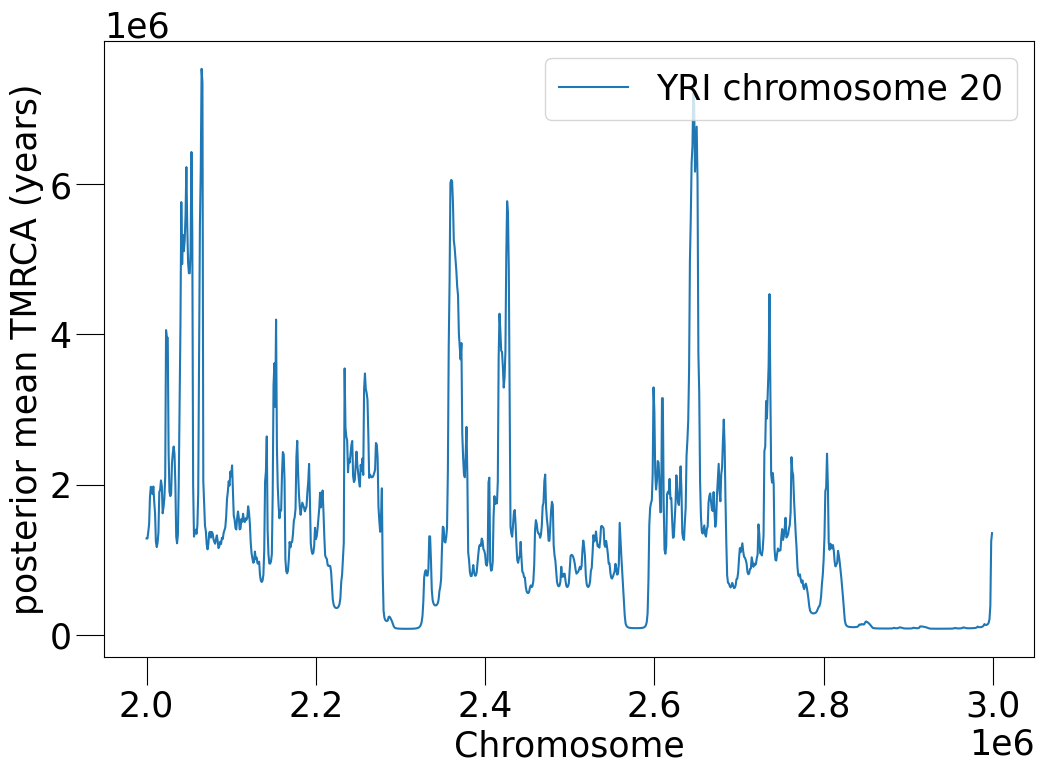

In [120]:
# posterior mean

posteriormean = sum(posteriors*time_years_midpoints[:,np.newaxis])
plt.plot(positions[start:end],posteriormean[start:end],label='YRI chromosome 20')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.xlabel('Chromosome')
plt.ylabel('posterior mean TMRCA (years)')
plt.legend()